In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.datasets import make_circles, make_moons

import scipy

import torch
import torch.nn as nn

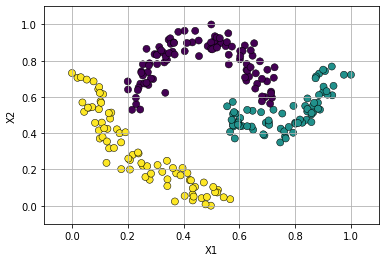

In [2]:
np.random.seed(249) ## 148, 249

xxc, yc = make_circles(n_samples=600, factor=.5,
                                      noise=.09)
idx = yc==0
xxc = xxc[idx]
yc = yc[idx]

idx = (xxc[:,0]+xxc[:,1]<-1)
xxc = xxc[idx]
yc = yc[idx]


xxm, ym = make_moons(n_samples=200, noise=.15)
xxm = xxm/2 - 0.2

msk0 = np.bitwise_and(ym==1 ,xxm[:, 0] > 0)
msk1 = ym==0
msk = msk0 | msk1
xxm = xxm[msk]
ym = ym[msk]

xx = np.concatenate((xxm, xxc), axis=0)
y = np.concatenate((ym, yc+2), axis=0)

## MinMax Normalization
x1 = xx[:,0]
x2 = xx[:,1]
x1 = (x1-x1.min())/(x1.max()-x1.min())
x2 = (x2-x2.min())/(x2.max()-x2.min())
xx = np.column_stack((x1,x2))

%matplotlib inline
plt.scatter(x1, x2, c=y, s=50, edgecolors='k', lw=0.5)

(x1min, x1max) = -0.1, 1.1
plt.xlim((x1min, x1max))
plt.ylim((x1min, x1max))
plt.xlabel("X1")
plt.ylabel('X2')
plt.grid()

In [3]:
def plot_results(X, Y_, means, covariances, alpha=0.2, covar_scale = [0.5, 1, 2] ):
    ax = plt.subplot(1, 1, 1)
    for i, (mean, covar) in enumerate(zip(
            means, covariances)):
        v, w = np.linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        sctp = plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], marker='.')

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        c = sctp.get_facecolor()[0]
    
        for scale in covar_scale:
            ell = matplotlib.patches.Ellipse(mean, v[0]*scale, v[1]*scale, 180. + angle, color=c)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(alpha/scale)
            ax.add_artist(ell)

In [14]:
class Gaussian(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.mean = nn.Parameter(torch.tensor([0], dtype=torch.float32, requires_grad=True))
        self.var = nn.Parameter(torch.tensor([1], dtype=torch.float32, requires_grad=True))
        
    def forward(self, x):
        return torch.exp(-0.5*(x-self.mean)**2/self.var) / (2 * torch.sqrt(self.var*np.pi))
    
    def NLL(self, x):
        t1 = -1/(2*self.var)*torch.mean((x-self.mean)**2) - torch.log(self.var)/2
        return t1

In [15]:
inp = torch.randn(200,1)*3-1
targ = torch.ones_like(inp)/len(inp)
gaus = Gaussian()

In [16]:
# list(gaus.parameters())

In [17]:
optim = torch.optim.SGD(gaus.parameters(), lr=0.5)
criterion = nn.MSELoss()

In [18]:
# yout = gaus(inp)
# optim.zero_grad()
# error = criterion(yout, targ)
# print(float(error))
# error.backward()
# optim.step()

In [19]:
for i in range(1000):
    NLL = -gaus.NLL(inp)
    optim.zero_grad()
    NLL.backward()
    optim.step()
    if i%10 == 0:
        print("NLL: ", float(NLL))
        print(f"Mean: {gaus.mean.data[0]}, Variance: {gaus.var.data[0]}")

NLL:  5.295855522155762
Mean: -0.574786365032196, Variance: 3.397927761077881
NLL:  1.8145195245742798
Mean: -1.006208062171936, Variance: 4.338077068328857
NLL:  1.7458603382110596
Mean: -1.1042273044586182, Variance: 4.892704963684082
NLL:  1.7110998630523682
Mean: -1.1334785223007202, Variance: 5.298840045928955
NLL:  1.6895718574523926
Mean: -1.1434272527694702, Variance: 5.621086597442627
NLL:  1.674867868423462
Mean: -1.1471006870269775, Variance: 5.888390064239502
NLL:  1.664201259613037
Mean: -1.14853835105896, Variance: 6.116567611694336
NLL:  1.6561332941055298
Mean: -1.1491260528564453, Variance: 6.315311908721924
NLL:  1.6498408317565918
Mean: -1.1493748426437378, Variance: 6.491031169891357
NLL:  1.644815444946289
Mean: -1.14948308467865, Variance: 6.6482038497924805
NLL:  1.6407256126403809
Mean: -1.1495314836502075, Variance: 6.790091514587402
NLL:  1.6373459100723267
Mean: -1.149553656578064, Variance: 6.919148921966553
NLL:  1.6345171928405762
Mean: -1.1495637893676758

In [20]:
yout = gaus(inp)

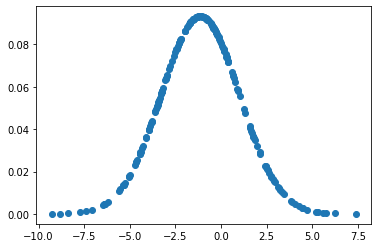

In [21]:
plt.scatter(inp.data.numpy(), yout.data.numpy())

In [24]:
print(f"GD   -> Mean: {gaus.mean.data[0]}, Variance: {gaus.var.data[0]}")
print(f"Torch-> Mean: {torch.mean(inp)}, Variance: {torch.var(inp)}")

GD   -> Mean: -1.1495720148086548, Variance: 9.157999992370605
Torch-> Mean: -1.1495728492736816, Variance: 9.316778182983398


In [ ]:
# https://github.com/mhdadk/Maximum-Likelihood-Estimation/blob/master/mle_gaussian.ipynb